In [1]:
import os
import urllib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping

In [3]:
import rasterio as rio
from rasterio.plot import show
import fiona
from rasterio import mask
from osgeo import gdal
from rasterio.features import shapes

In [4]:
from rasterio import merge

In [5]:
#Useful package to add dynamic scalebar to matplotlib images
from matplotlib_scalebar.scalebar import ScaleBar

In [6]:
#We want to use interactive plotting for zoom/pan and live coordinate display
#%matplotlib widget
%matplotlib inline

In [7]:
%cd final-project/

[Errno 2] No such file or directory: 'final-project/'
/home/jovyan/When-Glaciers-Were-Cool/final-project


In [71]:
imgdir = 'LS8_2021/'

#Pre-identified cloud-free Image IDs for this path/row 
img_id1 = 'LC08_L2SP_046026_20210420_20210430_02_T1_SR'   #START
img_id2 = 'LT05_L2SP_046026_19951006_20200912_02_T1_ST'   #PEAK
img_id3 = 'LC08_L2SP_046026_20210709_20210720_02_T1_SR'   #END

In [72]:
img = img_id1

In [73]:
#Specify filenames for different bands we will need for the lab
#Check table from background section to see wavelengths of each band number

#Red
r_fn = os.path.join(imgdir, img+'_B4.TIF')
#Green
g_fn = os.path.join(imgdir, img+'_B3.TIF')
#Blue
b_fn = os.path.join(imgdir, img+'_B2.TIF')
#Near-Infrared
nir_fn = os.path.join(imgdir, img+'_B5.TIF')
#Shortwave-Infrared
swir_fn = os.path.join(imgdir, img+'_B6.TIF')
#swir_fn = os.path.join(imgdir, img_1+'_B6.TIF')

#Panchromatic
p_fn = os.path.join(imgdir, img+'_B8.TIF')

In [74]:
src = rio.open(r_fn)

In [75]:
r = src.read(1)

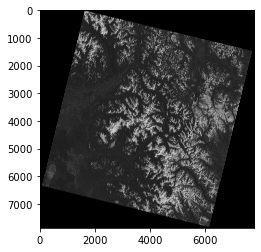

In [76]:
f, ax = plt.subplots()
ax.imshow(r, cmap='gray')

In [86]:
import rasterio.windows
#path 46
window = rasterio.windows.Window(2150, 3800, 1024, 1024)
#window = rasterio.windows.Window(1950, 3800, 1024, 1024)
#window = rasterio.windows.Window(2300, 4050, 400, 400)

In [87]:
#Define window bounds
window_bounds = rasterio.windows.bounds(window, src.transform)
print("Window bounds: ", window_bounds)
#Define window extent
window_extent = [window_bounds[0], window_bounds[2], window_bounds[1], window_bounds[3]]
print("Window extent: ", window_extent)

Window bounds:  (572385.0, 5386695.0, 603105.0, 5417415.0)
Window extent:  [572385.0, 603105.0, 5386695.0, 5417415.0]


In [88]:
def rio2ma(fn, b=1, window=None):
    with rio.open(fn) as src:
        #If working with PAN, scale offset and dimensions by factor of 2
        if 'B8' in fn and window is not None:
            window = rasterio.windows.Window(window.col_off*2, window.row_off*2, window.width*2, window.height*2)
        #Read in the window to masked array     
        a = src.read(b, window=window, masked=True)
        return a

In [89]:
r_fn_array = rio2ma(r_fn, b=1, window=window)
g_fn_array = rio2ma(g_fn, b=1, window=window)
b_fn_array = rio2ma(b_fn, b=1, window=window)
swir_fn_array = rio2ma(swir_fn, b=1, window=window)

In [90]:
def norm(a, perc_lim=(2, 98), clip=True):
    #Simple approach using actual min and max values
    #amin, amax = (a.min(), a.max())
    #Check if we're using masked array or np.nan
    if np.ma.isMaskedArray(a):
        amin, amax = np.percentile(a.compressed(), perc_lim)
    else:
        amin, amax = np.nanpercentile(a, perc_lim)
    print("Input range: ({}, {})".format(a.min(), a.max()))
    print("Percentile range: ({}, {})".format(amin, amax))
    out = ((a - amin)/(amax - amin))
    #This will "clip" normalized values <0 to 0 and >1 to 1
    if clip:
        out = out.clip(0,1)
    print("Output range: ({}, {})".format(out.min(), out.max()))
    return out

In [91]:
r_fn_norm = norm(r_fn_array, clip=True)
g_fn_norm = norm(g_fn_array, clip=True)
b_fn_norm = norm(b_fn_array, clip=True)
swir_fn_norm = norm(swir_fn_array, clip=True)

Input range: (114, 53262)
Percentile range: (7103.0, 47014.0)
Output range: (0.0, 1.0)
Input range: (522, 53963)
Percentile range: (7642.0, 47096.0)
Output range: (0.0, 1.0)
Input range: (14, 54249)
Percentile range: (6770.0, 47557.0)
Output range: (0.0, 1.0)
Input range: (5969, 35308)
Percentile range: (6928.0, 13937.0)
Output range: (0.0, 1.0)


In [92]:
rgb = np.dstack((r_fn_norm, g_fn_norm, b_fn_norm))
rgb.shape

(1024, 1024, 3)

In [93]:
ndsi = (g_fn_norm - swir_fn_norm)/(g_fn_norm + swir_fn_norm)

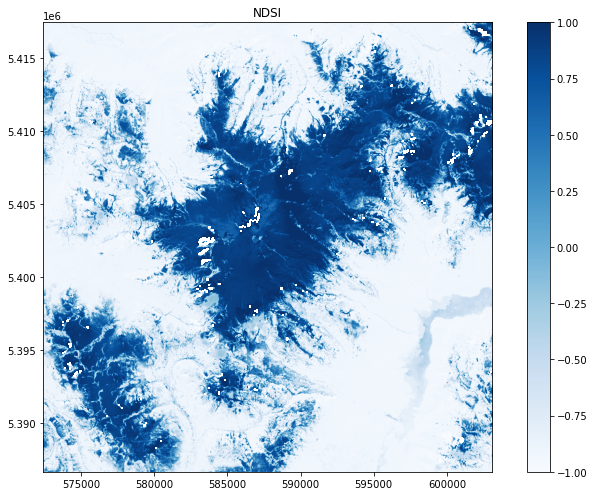

In [94]:
f, ax = plt.subplots(figsize=(10,7))

im = ax.imshow(ndsi, cmap='Blues', extent=window_extent)
#rgi_baker.plot(cmap='tab20', edgecolor='k', alpha=0.4, ax=ax, column=rgi_baker.Name, legend=True, legend_kwds={'loc': 'lower left', 'ncol': 2})

ax.set_title('NDSI')
plt.colorbar(im, ax=ax);
plt.tight_layout()

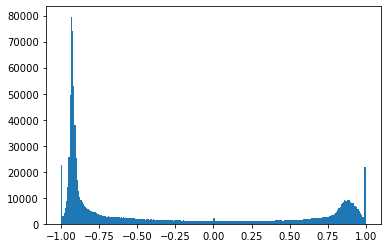

In [95]:
f, ax = plt.subplots()
h = ax.hist(ndsi.ravel(), bins=256)

In [96]:
#Use threshold of ~0.2-0.4 here
ndsi_thresh = 0.25
ndsi_mask = ndsi > ndsi_thresh

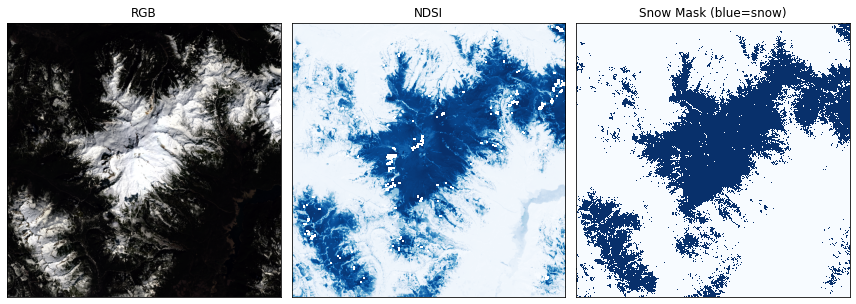

In [104]:
f, axa = plt.subplots(1, 3, sharex=True, tight_layout=True, sharey=True, figsize=(12,5))
axa[0].imshow(rgb, extent=window_extent)
axa[0].set_title('RGB')
#axa[0].add_artist(ScaleBar(1.0, location='upper right'))
axa[1].imshow(ndsi, cmap='Blues', extent=window_extent)
axa[1].set_title('NDSI')
axa[2].imshow(ndsi_mask, cmap='Blues', interpolation='none', extent=window_extent)
axa[2].set_title('Snow Mask (blue=snow)')
axa[0].tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)
axa[1].tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)
axa[2].tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)

f.savefig('glacier_analysis_2021.jpg', bbox_inches='tight', dpi=150);

In [98]:
rgi_baker = gpd.read_file('rgi_baker.json')
rgi_baker = rgi_baker.to_crs(32610)
shape = rgi_baker.iloc[0].geometry

In [99]:
sites_fn = 'snotel_conus_baker.json'
sites_gdf_all = gpd.read_file(sites_fn).set_index('index')
mygdf = sites_gdf_all.to_crs(32610)
color_list = ['C%i' % i for i in range(len(mygdf))]
color_list = ['red', 'red', 'red', 'red']

In [100]:
sites_gdf_all = gpd.read_file(sites_fn).set_index('index')
sites_gdf_all.head()

,code,name,network,elevation_m,site_property,geometry
index,,,,,,
SNOTEL:910_WA_SNTL,910_WA_SNTL,Elbow Lake,SNOTEL,926.591980,"{'county': 'Whatcom', 'state': 'Washington', '...",POINT (-121.90893 48.69092)
SNOTEL:999_WA_SNTL,999_WA_SNTL,Marten Ridge,SNOTEL,1072.895996,"{'county': 'Whatcom', 'state': 'Washington', '...",POINT (-121.69823 48.76292)
SNOTEL:1011_WA_SNTL,1011_WA_SNTL,MF Nooksack,SNOTEL,1514.855957,"{'county': 'Whatcom', 'state': 'Washington', '...",POINT (-121.92951 48.82453)
SNOTEL:909_WA_SNTL,909_WA_SNTL,Wells Creek,SNOTEL,1228.343994,"{'county': 'Whatcom', 'state': 'Washington', '...",POINT (-121.78976 48.86610)


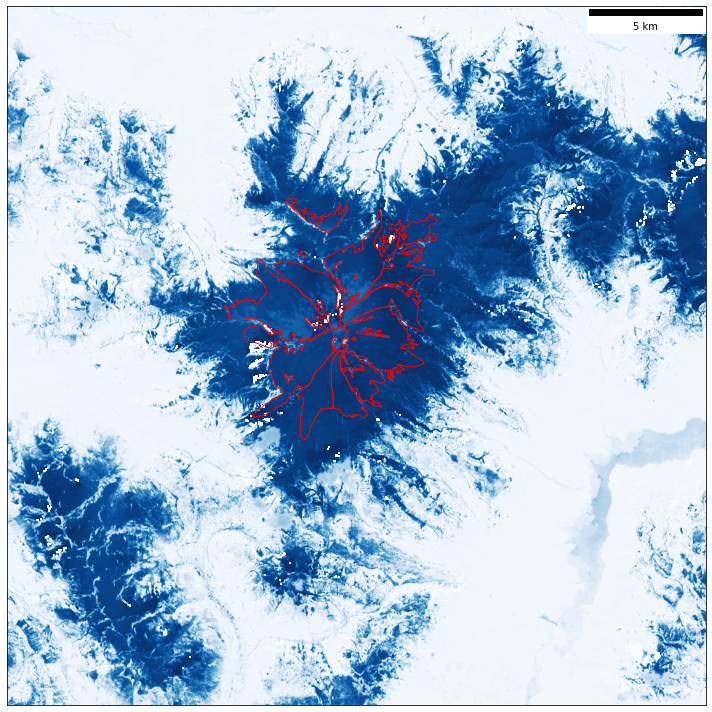

In [105]:
f, ax = plt.subplots(figsize=(10,10))

ax.imshow(ndsi, cmap='Blues', extent=window_extent)
#ax.set_title('First SWE, 2021')

#mygdf.plot(color='red', marker='', markersize=50, ax=ax)
#for x, y, label, c in zip(mygdf.geometry.x, mygdf.geometry.y, mygdf.code.str.split('_').str[0], color_list):
#    ax.annotate(label, xy=(x,y), xytext=(0, 0), ha='center', textcoords="offset points", color=c, fontsize=13, bbox=dict(boxstyle="square",fc='w',alpha=0.7))
    
rgi_baker.plot(#cmap='tab20', 
                facecolor='none',
                edgecolor='red', #alpha=0.25, 
               ax=ax, column=rgi_baker.Name)
               #legend=True, legend_kwds={'loc': 'lower left', 'ncol': 2})

ax.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)
ax.add_artist(ScaleBar(1.0))
plt.tight_layout()

#f.savefig('2021_peak.jpg', bbox_inches='tight', dpi=150)

### Do not run beyond this point! 

In [ ]:
out_profile = src.profile

In [ ]:
out_nodata = -9999

In [ ]:
out_profile.update(
    dtype=rasterio.float32,
    nodata=out_nodata)

In [281]:
ndsi_nodata = ndsi_mask.filled(out_nodata)

In [282]:
ndsi_mask

masked_array(
  data=[[False, False, False, ..., --, False, False],
        [False, False, False, ..., --, False, False],
        [False, False, False, ..., --, --, --],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  mask=[[False, False, False, ...,  True, False, False],
        [False, False, False, ...,  True, False, False],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=0)

In [283]:
with rasterio.open('mask_2021.tif', 'w', **out_profile) as dst:
    dst.write(ndsi_mask, 1)

In [284]:
src_ndsi = rasterio.open('mask_2021.tif')

In [285]:
r = src_ndsi.read(1)

In [45]:
out_img, out_transform = rasterio.mask.mask(src_ndsi, rgi_baker.geometry, crop=False, filled=True)

In [46]:
out_img = out_img.squeeze()

In [125]:
out_img = out_img > 0.99

In [166]:
rgi_bounds = rgi_baker.unary_union.bounds
rgi_bounds

(581947.277910863, 5398360.451522439, 591330.2536310479, 5409027.9499451555)

In [167]:
#glacier_bounds = rasterio.windows.bounds(rgi_baker, src.transform)
#print("Window bounds: ", glacier_bounds)
#Define window extent
glacier_extent = [rgi_bounds[0], rgi_bounds[2], rgi_bounds[1], rgi_bounds[3]]
print("Window extent: ", glacier_extent)

Window extent:  [581947.277910863, 591330.2536310479, 5398360.451522439, 5409027.9499451555]


In [46]:
with rasterio.open('peak_2021.tif', 'w', **out_profile) as dst:
    dst.write(out_img, 1)

In [47]:
out_image, out_meta = es.crop_image(src_ndsi, rgi_baker.geometry)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
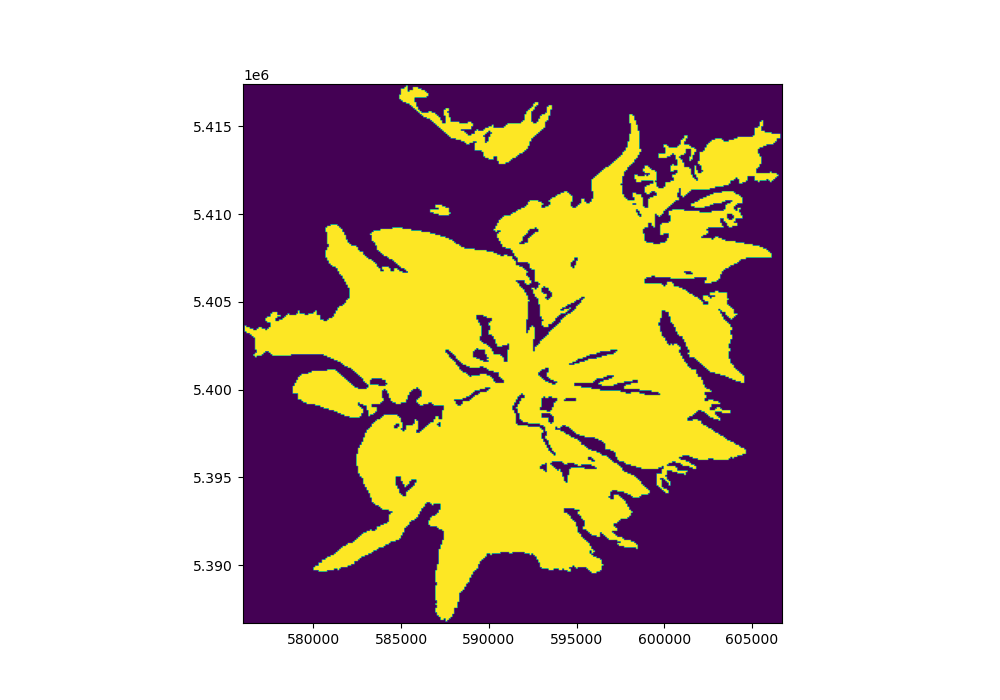

In [48]:
f, ax = plt.subplots(figsize=(10,7))

im = ax.imshow(out_img, extent=window_extent)
#rgi_baker.plot(cmap='tab20', facecolor='none', edgecolor='k', ax=ax, column=rgi_baker.Name, legend=False, legend_kwds={'loc': 'lower left', 'ncol': 2})


In [ ]:
# in-memory file to store 